# Shifted Beta Geometric model with individual customer data

In this notebook we replicate the main results and figures from 

Fader, P. S., & Hardie, B. G. (2007). How to project customer retention. Journal of Interactive Marketing, 21(1), 76-90. https://journals.sagepub.com/doi/pdf/10.1002/dir.20074

The authors describe the Shifted Beta Geometric (sBG) model for customer behavior in a discrete contractual setting. It assumes that:
  * At the end of each period, a customer has a probability `theta` of renewing the contract
    and `1-theta` of cancelling
  * The probability `theta` does not change over time for a given customer
  * The probability `theta` varies across customers according to a Beta prior distribution
    with hyperparameters `alpha` and `beta`.

In [1]:
import arviz as az
import scipy.stats as st
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

In [2]:
from pymc_marketing import clv

In [3]:
az.style.use("arviz-darkgrid")

## Recreating the dataset

The dataset contains the percentage of customers still enrolled in the service after each time period. There are two distinct groups of users: regular and high-end, believed to have different attrition rates. Each group had 1000 customers at the start.

As in the original paper, we will fit the data from the first 7 time periods only, and use the following periods for validation.

In [4]:
df = pd.DataFrame({
    "regular": [100.0, 63.1, 46.8, 38.2, 32.6, 28.9, 26.2, 24.1, 22.3, 20.7, 19.4, 18.3, 17.3],
    "highend": [100.0, 86.9, 74.3, 65.3, 59.3, 55.1, 51.7, 49.1, 46.8, 44.5, 42.7, 40.9, 39.4],
})
df

,regular,highend
0,100.0,100.0
1,63.1,86.9
2,46.8,74.3
3,38.2,65.3
4,32.6,59.3
5,28.9,55.1
6,26.2,51.7
7,24.1,49.1
8,22.3,46.8
9,20.7,44.5


The implemented pymc-marketing model fits each individual `theta`, 
in contrast to the paper approach where the inidividual parameters are marginalized out.

For our analysis we wil have to create a synthetic dataset with individual data, following the aggregate group trends.

In [5]:
def individual_data_from_percentage_alive(percentage_alive, initial_customers):
    n_alive = np.asarray(percentage_alive / 100 * initial_customers, dtype=int)
    
    died_at = np.zeros((initial_customers,), dtype=int)
    counter = 0
    for t, diff in enumerate((n_alive[:-1] - n_alive[1:]), start=1):
        died_at[counter:counter+diff] = t
        counter += diff

    censoring_t = t+1
    died_at[counter:] = censoring_t
    
    return died_at

In [6]:
T = 8  # In the paper only the first 7 years are included in the model

truncated_df = df[:T]
initial_customers = 1000  # Seems to be what F&H use, according to Appendix B
churn_highend = individual_data_from_percentage_alive(truncated_df["highend"], initial_customers)
churn_regular = individual_data_from_percentage_alive(truncated_df["regular"], initial_customers)
churn_regular[::10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 5, 5, 5, 5, 6, 6, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])

Customers which haven't churned have `t_churn == T == 8`. 
The model will handle these differently, as their lifetimes are [censored](https://en.wikipedia.org/wiki/Censoring_(statistics)).

## Fitting the sBG models for high end and regular users

In [7]:
highend_users = clv.ShiftedBetaGeoModelIndividual(
    customer_id = np.arange(initial_customers),
    t_churn = churn_highend,
    T = T,
)
highend_users

Shifted-Beta-Geometric Model (Individual Customers)
         alpha ~ HalfFlat()
          beta ~ HalfFlat()
         theta ~ Beta(alpha, beta)
churn_censored ~ Censored(Geom(theta), -inf, 8)

In [8]:
regular_users = clv.ShiftedBetaGeoModelIndividual(
    customer_id = np.arange(initial_customers),
    t_churn = churn_regular,
    T = T,
)
regular_users

Shifted-Beta-Geometric Model (Individual Customers)
         alpha ~ HalfFlat()
          beta ~ HalfFlat()
         theta ~ Beta(alpha, beta)
churn_censored ~ Censored(Geom(theta), -inf, 8)

In [9]:
highend_users.fit()
regular_users.fit();

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 89 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 59 seconds.


## Contrasting posterior inferences with the repo MLE estimates

The sBG model has 2 population parameters of interest: `alpha` and `beta`. 
These parameters define the population distribution of the individual customer's churn rates `theta`. 
The larger the values of `alpha` and `beta` the more homogenous the churn rates are across different customers. 

The ratio of `alpha` to `beta` tells us the expected churn rates. If `alpha/beta == 0.1`, we expect the average customer to have a `0.1` probability of churning between each time period.

In [10]:
# MLE estimates from the paper
ref_val = {
    "highend": [0.704, 3.806],
    "regular": [0.688, 1.182],
}

In [11]:
highend_users.fit_summary(var_names=["alpha", "beta"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.764,0.171,0.504,1.108,0.025,0.018,48.0,89.0,1.02
beta,4.575,1.356,2.625,7.315,0.200,0.142,48.0,89.0,1.02


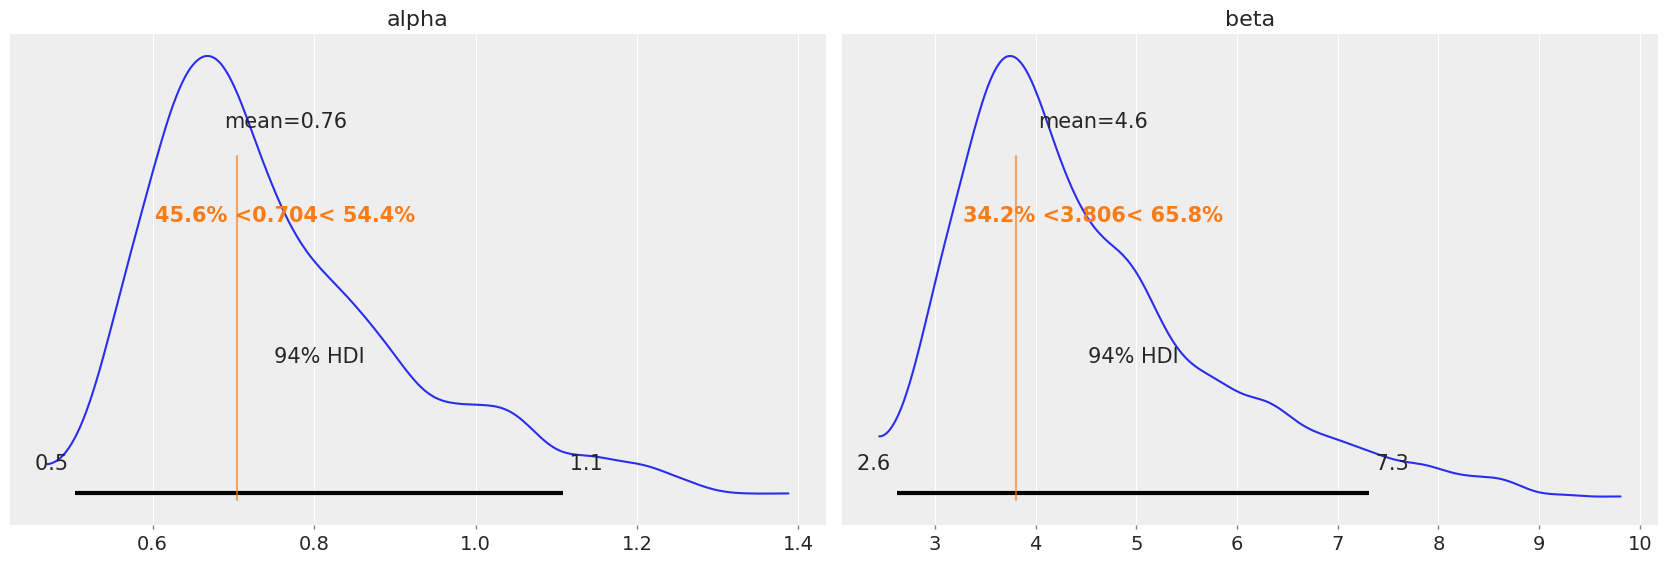

In [12]:
az.plot_posterior(
    highend_users.fit_result, 
    var_names=["alpha", "beta"],
    ref_val=ref_val["highend"]
);

In [13]:
regular_users.fit_summary(var_names=["alpha", "beta"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.718,0.067,0.599,0.843,0.006,0.004,129.0,319.0,1.01
beta,1.221,0.159,0.973,1.554,0.014,0.010,126.0,312.0,1.01


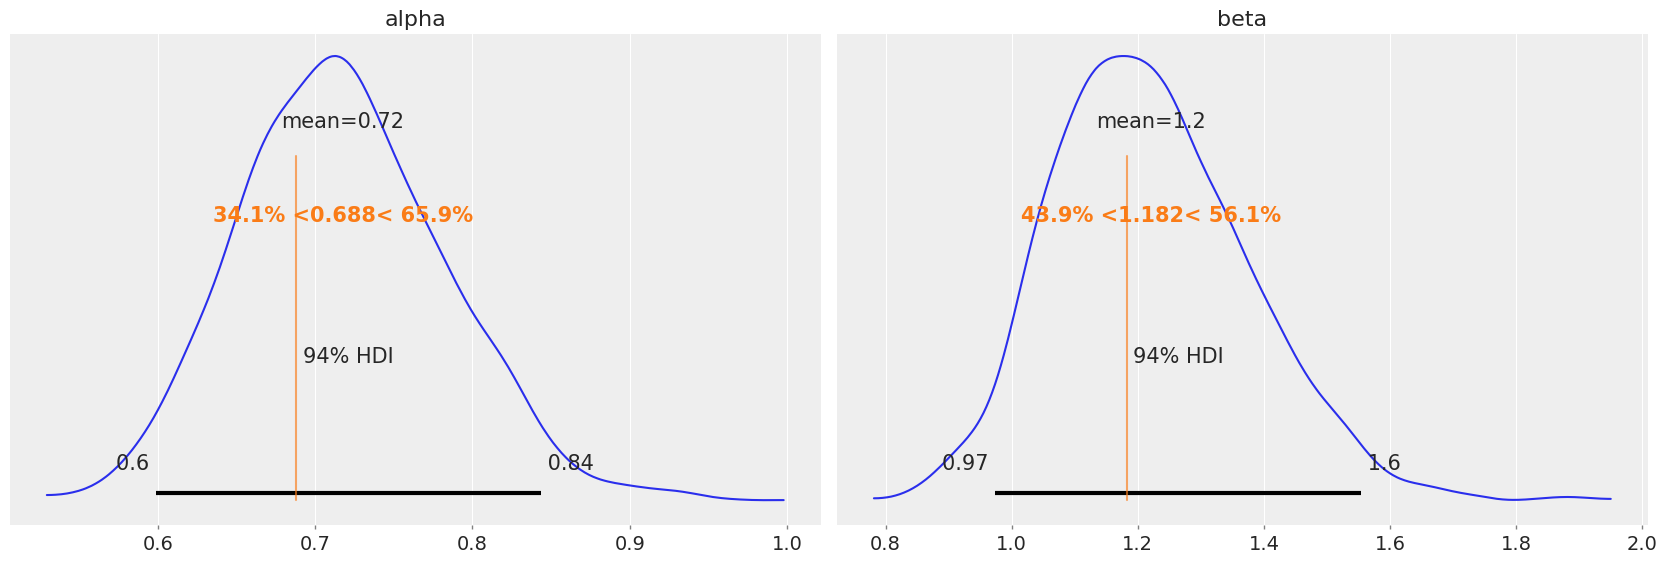

In [14]:
az.plot_posterior(
    regular_users.fit_result, 
    var_names=["alpha", "beta"],
    ref_val=ref_val["regular"]
);

The model fitting agrees with the Maximum Likelihood estimates described in the original paper.
In addition, MCMC sampling, gives us useful information about the uncertainty of the fits.

## Recreating main results and figures from the paper

Figure 6 from the paper shows the group distribution of `theta` churn rates. 

The inferred distributions are relatively wide in both groups, which follows directly from the fact that both `alpha` and `beta` were inferred to be < 10.

It is still clear that the distribution of `theta` for the highend users has much more mass near lower values,
suggesting highend users have lower attrition rates on average, when compared with regular users.

In [15]:
new_highend_theta = highend_users.distribution_new_customer_theta(n=100)
new_regular_theta = regular_users.distribution_new_customer_theta(n=100);

Sampling: [theta]


Sampling: [theta]


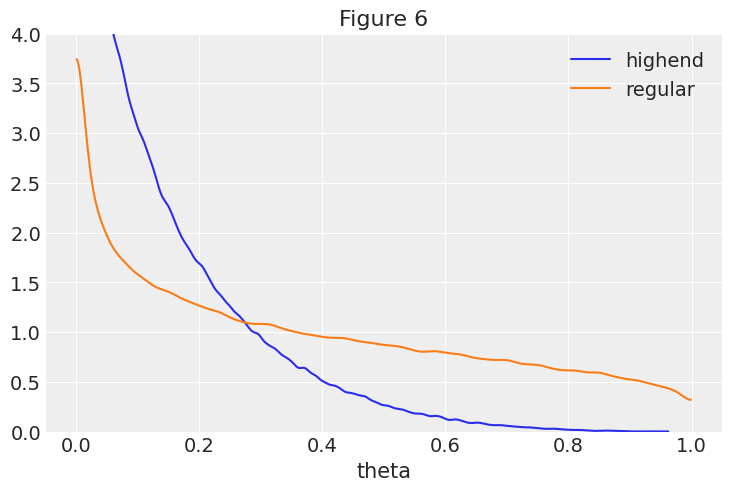

In [16]:
ax = az.plot_dist(new_highend_theta, label="highend")
ax = az.plot_dist(new_regular_theta, label="regular", ax=ax, color="C1")
ax.set_xlabel("theta")
plt.ylim([0, 4])
ax.set_title("Figure 6");

Figures 4 and 5 show the predicted average churn and retention trends for the two groups.
We can see that predictions nicely match the observed data (black line), even when extrapolating into the time periods that were held-out when fitting the model.

The plots also highlight an interesting implication from the model: 
the retention rates are expected to increase over time, as the more precarious customers gradually drop out. This is a direct consequence of modelling individual churn rates as being fixed over time.

In [17]:
churn_highend = highend_users.distribution_customer_churn_time(
    customer_id=np.arange(initial_customers)
)
churn_regular = regular_users.distribution_customer_churn_time(
    customer_id=np.arange(initial_customers)
)

Sampling: [churn]


Sampling: [churn]


In [18]:
weeks = xr.DataArray(np.arange(1, 14), dims=["weeks"])

survival_perc_highend = 100-100*((churn_highend < weeks))
survival_perc_regular = 100-100*((churn_regular < weeks))

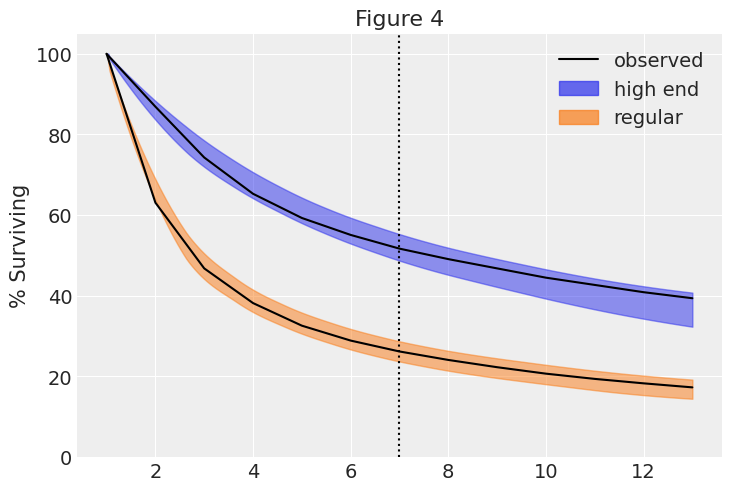

In [19]:
az.plot_hdi(weeks, survival_perc_highend.mean("customer_id"), hdi_prob=.95, color="C0")
az.plot_hdi(weeks, survival_perc_regular.mean("customer_id"), hdi_prob=.95, color="C1")

plt.plot(weeks, df["highend"], color="k", label="observed")
plt.plot(weeks, df["regular"], color="k")

plt.axvspan(None, None, color="C0", alpha=0.7, label="high end")
plt.axvspan(None, None, color="C1", alpha=0.7, label="regular")

plt.axvline(7, ls=':', color="k")
plt.ylim([0, 105])
plt.ylabel("% Surviving")
plt.legend()
plt.title("Figure 4");

In [20]:
retention_rate_highend = (
    survival_perc_highend.isel(weeks=slice(1, None, None)) 
    / survival_perc_highend.isel(weeks=slice(None, -1, None))
)
retention_rate_regular = (
    survival_perc_regular.isel(weeks=slice(1, None, None)) 
    / survival_perc_regular.isel(weeks=slice(None, -1, None))
)

retention_rate_highend_obs = df["highend"][1:].values / df["highend"][:-1].values
retention_rate_regular_obs = df["regular"][1:].values / df["regular"][:-1].values

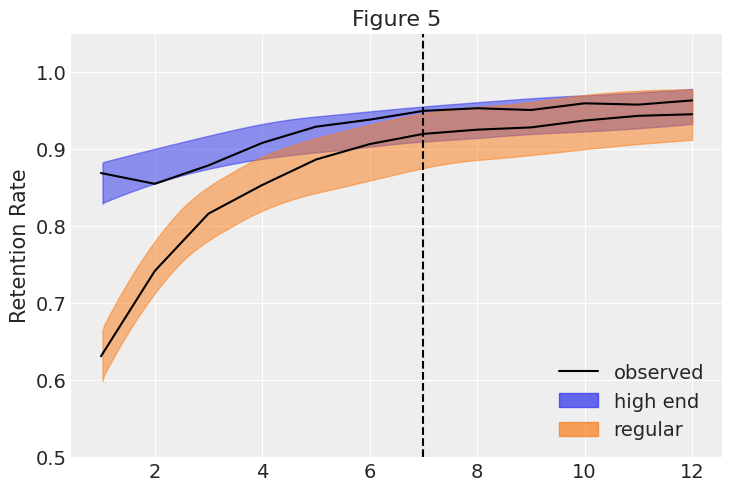

In [21]:
weeks_ = weeks[:-1]

az.plot_hdi(weeks_, retention_rate_highend.mean("customer_id"), hdi_prob=.95, color="C0")
az.plot_hdi(weeks_, retention_rate_regular.mean("customer_id"), hdi_prob=.95, color="C1")

plt.plot(weeks_, retention_rate_highend_obs, color="k", label="observed")
plt.plot(weeks_, retention_rate_regular_obs, color="k")

plt.axvspan(None, None, color="C0", alpha=0.7, label="high end")
plt.axvspan(None, None, color="C1", alpha=0.7, label="regular")

plt.axvline(7, ls='--', color="k")
plt.ylim([0.5, 1.05])
plt.ylabel("Retention Rate")
plt.legend()
plt.title("Figure 5");